In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #visualizations
import tensorflow as tf #to get keras

keras = tf.keras
layers = keras.layers #layers of NN
Tokenizer = keras.preprocessing.text.Tokenizer #to encode the tweets

from sklearn.metrics import classification_report, confusion_matrix # Evaluate with confusion matrix and classification report
import seaborn as sns


In [2]:
dset = pd.read_csv(r'C:/Users/user/Downloads/labeled_data/labeled_data.csv')
dset.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


classes
*  0- hate speech
*  1- offensive
*  2- neutral

In [3]:
dset = dset.drop(dset.columns[:5], axis=1) #removing the first 5 columns
dset.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
feature_columns = ['hate_speech','offensive', 'neutral'] 

### preprocessing

In [5]:
# split the dataset
num_rows = len(dset.index)
train_set = round(num_rows*0.8)
train_set

train_ft = dset[0:train_set] 
test_ft = dset[train_set:]

In [6]:
train_labels=train_ft.pop('class')
test_labels= test_ft.pop('class')

In [7]:
print(train_ft.shape)
print(train_labels.shape)
print(test_ft.shape)
print(test_labels.shape)

(19826, 1)
(19826,)
(4957, 1)
(4957,)


### encoding words
transform tweets into integer arrays for training

In [8]:
padding_type = 'pre'
max_len = 60  # words per comment
trun_type = 'post'
oov_token = '<oov>' #out of vocab

tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(train_ft['tweet'])

vocab_size = len(tokenizer.word_index) + 1 # add 1 to fix out of bound index error
vocab_size
#tokenizer.word_index

32752

In [9]:
#convert panda df into numpy array

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# pass the array for 3 classes
train_labels = keras.utils.to_categorical(train_labels,3)
test_labels = keras.utils.to_categorical(test_labels,3)

In [10]:
# convert tweets to sequences -encode 
train_ft_seq = tokenizer.texts_to_sequences(train_ft['tweet'])
test_ft_seq = tokenizer.texts_to_sequences(test_ft['tweet'])

padding the array

In [11]:
train_ft_seq = keras.utils.pad_sequences(train_ft_seq, max_len, padding=padding_type)
test_ft_seq = keras.utils.pad_sequences(test_ft_seq, max_len, padding=padding_type)

In [12]:
train_ft_seq = np.array(train_ft_seq)
test_ft_seq = np.array(test_ft_seq)
test_ft_seq.shape

(4957, 60)

### data model building

In [13]:
num_of_classes = len(feature_columns)

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 32, input_length=max_len),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dense(num_of_classes, activation='softmax')
])
model.build(input_shape=(None, max_len))  

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 32)            1048064   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 1064899 (4.06 MB)
Trainable params: 1064899 (4.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
history = model.fit(train_ft_seq, train_labels, epochs=10, verbose=2)

Epoch 1/10


620/620 - 38s - loss: 0.4480 - accuracy: 0.8476 - 38s/epoch - 62ms/step
Epoch 2/10
620/620 - 31s - loss: 0.2371 - accuracy: 0.9186 - 31s/epoch - 49ms/step
Epoch 3/10
620/620 - 22s - loss: 0.1402 - accuracy: 0.9540 - 22s/epoch - 36ms/step
Epoch 4/10
620/620 - 21s - loss: 0.0752 - accuracy: 0.9740 - 21s/epoch - 34ms/step
Epoch 5/10
620/620 - 21s - loss: 0.0460 - accuracy: 0.9852 - 21s/epoch - 34ms/step
Epoch 6/10
620/620 - 21s - loss: 0.0300 - accuracy: 0.9912 - 21s/epoch - 34ms/step
Epoch 7/10
620/620 - 21s - loss: 0.0193 - accuracy: 0.9944 - 21s/epoch - 34ms/step
Epoch 8/10
620/620 - 22s - loss: 0.0158 - accuracy: 0.9953 - 22s/epoch - 35ms/step
Epoch 9/10
620/620 - 22s - loss: 0.0119 - accuracy: 0.9969 - 22s/epoch - 35ms/step
Epoch 10/10
620/620 - 21s - loss: 0.0088 - accuracy: 0.9973 - 21s/epoch - 35ms/step


In [17]:
history.history['accuracy'][-1]

0.9972763061523438

C:\Users\user\AppData\Local\Temp\ipykernel_13856\1554956228.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


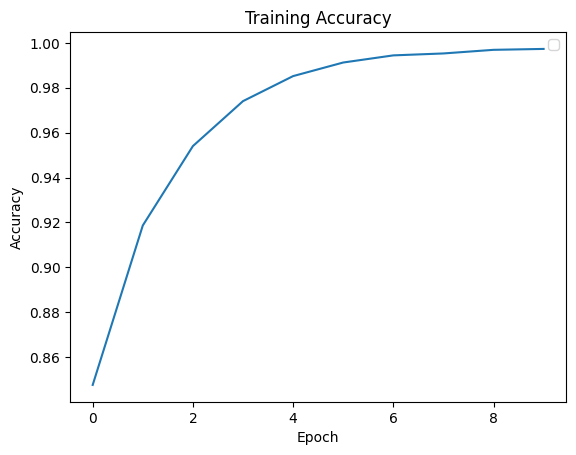

C:\Users\user\AppData\Local\Temp\ipykernel_13856\1554956228.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


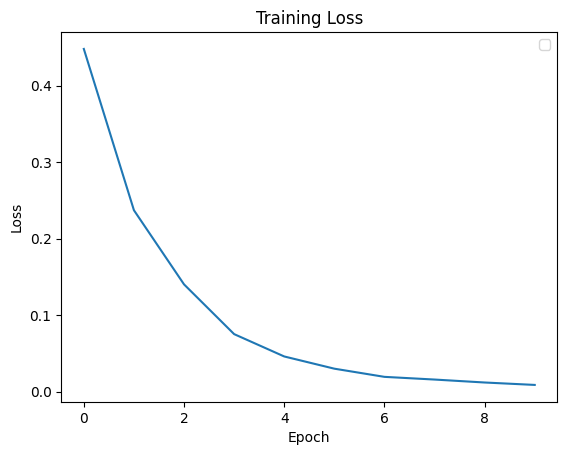

In [18]:
#Training & validation curves
# Accuracy
plt.figure()
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title('Training Accuracy')
plt.show()

# Loss
plt.figure()
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Training Loss')
plt.show()

In [19]:
model.save('Keras_Hatespeech_model.h5')  # Save the model in HDF5 format

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# Tokenize and pad the test tweets
test_sequences = tokenizer.texts_to_sequences(test_ft['tweet'])
test_padded = keras.utils.pad_sequences(test_sequences, padding='pre', truncating='post', maxlen=60)

# Predict on the full test set
pred_test = model.predict(test_padded)

pred_test_classes = np.argmax(pred_test, axis=1)
true_test_classes = np.argmax(test_labels, axis=1)

155/155 [==============================] - 2s 8ms/step


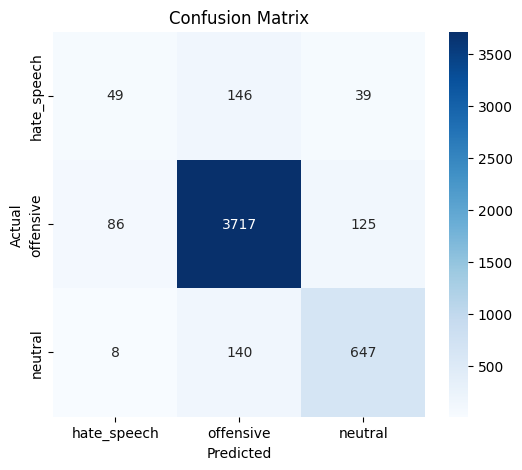

In [21]:
# Compute confusion matrix
cm = confusion_matrix(true_test_classes, pred_test_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=feature_columns, yticklabels=feature_columns)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
print("\nClassification Report:")
print(classification_report(true_test_classes, pred_test_classes, target_names=feature_columns))



Classification Report:
              precision    recall  f1-score   support

 hate_speech       0.34      0.21      0.26       234
   offensive       0.93      0.95      0.94      3928
     neutral       0.80      0.81      0.81       795

    accuracy                           0.89      4957
   macro avg       0.69      0.66      0.67      4957
weighted avg       0.88      0.89      0.88      4957



### predict a comment 

In [23]:
import json

with open('hate_comment_detection.json','w') as file:
    json.dump(tokenizer.word_index, file)

In [24]:
with open('hate_comment_detection.json','r') as file:
    data = json.load(file)

word_index = dict(data)

In [25]:
#random_tweet = 'i love you'
random_tweet = 'I really wanna kill you'
#random_tweet = 'what a dog'
#random_tweet = 'just die. you whore'

oov_token = '<oov>'

tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.word_index = word_index
encoded = tokenizer.texts_to_sequences([random_tweet])
encoded = keras.utils.pad_sequences(encoded, padding='pre', truncating='post',maxlen=60)


In [26]:
pred_new = model.predict(encoded)

1/1 [==============================] - 0s 32ms/step


In [27]:
print("Predicted probabilities:", pred_new[0])
print("Highest confidence score:", np.max(pred_new[0]))
print("Predicted class index:", np.argmax(pred_new[0]))
print("Predicted class label:", feature_columns[np.argmax(pred_new[0])])


Predicted probabilities: [0.6832117  0.10835071 0.2084377 ]
Highest confidence score: 0.6832117
Predicted class index: 0
Predicted class label: hate_speech
